In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, solve_ivp, fixed_quad, simpson
from scipy.special import kn
import astropy.constants as ct
import pandas as pd
from scipy.optimize import newton,curve_fit
from scipy.interpolate import interp1d
from scipy.differentiate import derivative
import concurrent.futures

In [3]:
# Constants

vev = 246 # GeV - Higgs VEV
m_h = 125.2 # GeV - Higgs mass
Gamma_h = 4.07e-3 # GeV - total Higgs decay width
M_W = 80.3692 # GeV - W boson mass
M_Z = 91.188 # GeV - Z boson mass

m_e = 0.511e-3 # GeV - electron mass
m_muon = 105.66e-3 # GeV - muon mass
m_tau = 1.77693 # GeV - tau mass
m_u = 2.16e-3 # GeV - up mass
m_d = 4.7e-3 # GeV - down mass
m_c = 1.273 # GeV - charm mass
m_s = 93.5e-3 # GeV - strange mass
m_t = 172.57 # GeV - top mass
m_b = 4.183 # GeV - bottom mass

M_V = [M_W, M_Z]
M_f = [m_e,m_muon,m_tau,m_u,m_d,m_c,m_s,m_t,m_b]
n_cs = [1,1,1,3,3,3,3,3,3]

c_V = [1,1/2]

g_V = 3
g_f = 2

# C = 0.349 # no sé qué es esto
C = 1 - 5.792e-1 -6.240e-2 - 2.165e-4 - 2.876e-4

gstar = 106.75
MP = 2.4e18
T0 = 2.725*ct.k_B.value/ct.e.value*1e-9
gstars0 = 3.91
gstar0 = 3.38
s0 = 2*np.pi**2/45*gstars0*T0**3
rhoc0 = 4.78658e-5*1e6*ct.c.value**3*ct.hbar.value**3/ct.e.value**3*(1e-9)**4 # GeV⁴
gS = 1

s0mo = 2.8912e9*(ct.c.value/ct.hbar.value*ct.e.value*1e-9)**(-3)
rhoc0mo = 10.537*(ct.c.value/ct.hbar.value*ct.e.value*1e-9)**(-3)

In [4]:
# Relativistic degrees of freedom
rdof = pd.read_csv('https://raw.githubusercontent.com/SantiagoJulioD/Trabajo_de_grado/refs/heads/main/FIMP_fermion/rdof.csv')
rdof.loc[250,'Temp'] = T0
rdof['lnTemp'] = np.log(rdof['Temp'])
rdof['lnheff'] = np.log(rdof['g_s'])

In [5]:
# SM particles
SM_particles = pd.DataFrame(index=['h','W','Z','e','mu','tau','u','d','c','s','t','b'])
SM_particles['mass'] = np.array([m_h,]+M_V+M_f)
SM_particles['spin'] = np.array([0,1,1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
SM_particles['n_c'] = np.array([1,1,1,1,1,1,3,3,3,3,3,3])
SM_particles['dof'] = 2*SM_particles['spin']+1
SM_particles['antiparticle'] = np.array([0.5,1,0.5,1,1,1,1,1,1,1,1,1])
SM_particles['name'] = np.array(['Higgs','W± boson','Z0 boson','electron','muon','tau','up quark','down quark','charm quark','strange quark','top quark','bottom quark'])

In [6]:
# RDOF equations
heff = interp1d(rdof['Temp'][::-1],rdof['g_s'][::-1],bounds_error=False,fill_value=(rdof['g_s'].values[-1],rdof['g_s'].values[0]))
geff = interp1d(rdof['Temp'][::-1],rdof['g_rho'][::-1],bounds_error=False,fill_value=(rdof['g_rho'].values[-1],rdof['g_rho'].values[0]))
lnheff = interp1d(rdof['lnTemp'][::-1],rdof['lnheff'][::-1],bounds_error=False,fill_value=(rdof['lnheff'].values[-1],rdof['lnheff'].values[0]))
der = derivative(lnheff,rdof['lnTemp']).df
dlnheffdlnT = interp1d(rdof['lnTemp'][::-1],der[::-1],bounds_error=False,fill_value=(der[-1],der[0]))

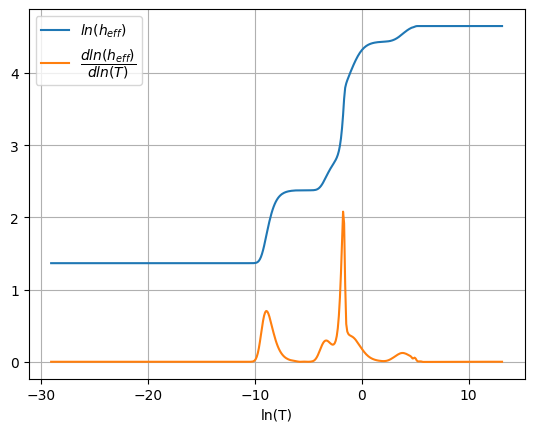

In [7]:
# Graph of RDOF
der = derivative(lnheff,rdof['lnTemp']).df

plt.plot(rdof['lnTemp'],rdof['lnheff'],label=r'$ln(h_{eff})$')
plt.plot(rdof['lnTemp'],dlnheffdlnT(rdof['lnTemp']),label=r'$\dfrac{dln(h_{eff})}{dln(T)}$')
plt.xlabel('ln(T)')
plt.grid()
plt.legend()
plt.show()

In [18]:
def scale_factor(T):
    a_int = lambda lnT: (1+1/3*dlnheffdlnT(lnT))
    scalefactor = np.exp(quad(a_int,np.log(T),np.log(T0),limit=1000)[0])
    return scalefactor
scale_factor = np.vectorize(scale_factor)

In [11]:
def Gamma_hSS(lambda_HS,M_S):
    return (lambda_HS**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2+0j)**0.5).real

In [12]:
def dYdT(T,M_S,lambda_HS):
    H = (np.pi**2/90*geff(T))**0.5*T**2/MP
    const = m_h**2/(2*np.pi**2)*C*Gamma_hSS(lambda_HS,M_S)
    func = scale_factor(T)**3/H*const*kn(1,m_h/T)*(1+1/3*dlnheffdlnT(np.log(T)))
    return func

In [28]:
TR = 1e6
Ts = np.logspace(np.log10(T0),np.log10(TR),100)
Ip = 0
for i in range(len(Ts)-1):
    Ip += quad(dYdT,Ts[i],Ts[i+1],args=(1,1e-11))[0]

/tmp/ipykernel_13495/2642557001.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  scalefactor = np.exp(quad(a_int,np.log(T),np.log(T0),limit=1000)[0])


/tmp/ipykernel_13495/2642557001.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  scalefactor = np.exp(quad(a_int,np.log(T),np.log(T0),limit=1000)[0])


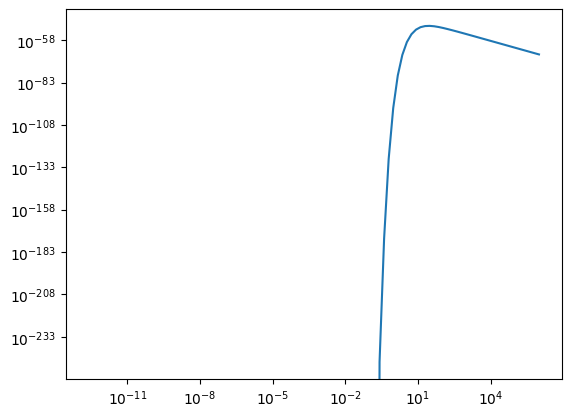

In [32]:
plt.loglog(Ts,dYdT(Ts,1,1e-11))

In [ ]:
def Boltz_eq(x,M_S,lambda_HS):
    HMS = (np.pi**2*geff(M_S/x)/90)**0.5*M_S**2/MP
    sMS = 2*np.pi**2/45*heff(M_S/x)*M_S**3
    exponent_f = lambda u: 1+1/3*dlnheffdlnT(np.log(M_S/u))
    x0 = M_S/T0
    exponent = quad(exponent_f,np.log(x0),np.log(x),limit=100)[0]
    ax = np.exp(exponent)
    return s0mo*M_S*x**4/(HMS*sMS)*(C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))/rhoc0mo

In [43]:
TR=1e6
xs = np.logspace(np.log10(1/TR),np.log10(1/T0),15)
xs

array([1.00000000e-06, 2.14122089e-05, 4.58482690e-04, 9.81712713e-03,
       2.10206377e-01, 4.50098286e+00, 9.63759852e+01, 2.06362273e+03,
       4.41867209e+04, 9.46135299e+05, 2.02588467e+07, 4.33786657e+08,
       9.28833052e+09, 1.98883673e+11, 4.25853876e+12])

In [44]:
# integral para el decaimiento del Higgs
Ip = 0
for i in range(len(xs)-1):
    I = quad(Boltz_eq,xs[i],xs[i+1],args=(1,1e-11),limit=10000)
    Ip += I[0]
    print(I[1])

1.1413986304501638e-17
9.406014650295847e-14
1.3174861906640187e-08
1.361372571145836e-08
1.2014120648129682e-10
4.737508204134493e-244
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [45]:
# integral para el decaimiento del Higgs
Ip = 0
for i in range(len(xs)-1):
    x_ = np.linspace(xs[i],xs[i+1],1000)
    I = simpson(Boltz_eq(x_,1,1e-11),x_)
    Ip += I

In [46]:
Ip

0.013634281671602414

In [59]:
Ts = np.logspace(np.log10(T0),12,100000)
I = simpson(func(Ts),Ts)
K = T0**3*m_h**2*C/((np.pi**2/(90*MP**2)*gstar)**0.5*2*np.pi)

def coupling(M_S):
    den = K*Ip[0]*vev**2/(32*np.pi*m_h*(1-4*M_S**2/m_h**2)**0.5*M_S*(0.68)**2/rhoc0)
    return (0.12/den)**0.5

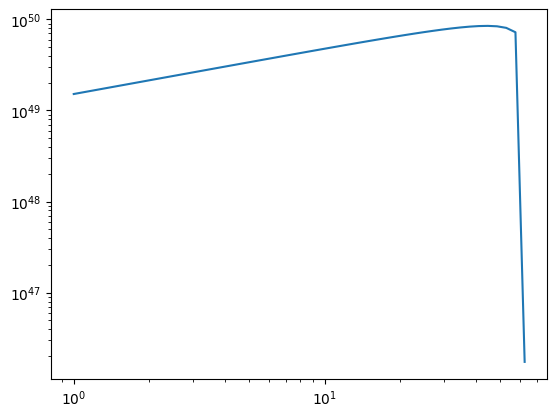

In [ ]:
Ms = np.logspace(0,np.log10(m_h/2))
plt.loglog(Ms,coupling(Ms))